# Imports

In [1]:
import webdriver_manager
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from webdriver_manager.firefox import GeckoDriverManager
from selenium.webdriver.chrome.service import Service as ChromeService
from IPython.display import clear_output
import time
import pandas as pd
import IPython
import os
from decouple import config

# Driver and Functions

In [2]:
driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()))

[WDM] - Downloading: 100%|██████████| 7.26M/7.26M [00:00<00:00, 17.9MB/s]


In [3]:
def login():
    driver.get("https://ocs.iitd.ac.in/portal/login")
    ID = config("OCS_ID")
    password = config("OCS_PASSWORD")
    driver.get("https://ocs.iitd.ac.in/portal/login")
    driver.find_element(By.ID, "mat-input-0").send_keys(ID)
    driver.find_element(By.ID, "mat-input-1").send_keys(password)
    captcha = driver.find_element(By.TAG_NAME, "object")
    captcha.screenshot("captcha.png")
    IPython.display.display(IPython.display.Image("captcha.png"))
    captcha_code = input("Enter the captcha code: ")
    driver.find_element(By.ID, "mat-input-2").send_keys(captcha_code)
    driver.find_element(By.TAG_NAME, "button").click()

In [4]:
def list_companies(url = "https://ocs.iitd.ac.in/portal/student/applications", class1= "mat-select-value-5", class2 = "mat-option-14"):
    driver.get(url)
    driver.find_element(By.ID, class1).click()
    driver.find_element(By.ID, class2).click()
    max_rows = int(driver.find_element(By.CLASS_NAME, "mat-paginator-range-label").text.split(" ")[-1])
    return max_rows

In [5]:
def result(max_rows):
    companies = []
    profiles = []
    page_num = 0
    per_page = 50
    while page_num*per_page<=max_rows:
        print(f"Currently on page {page_num+1}", end="\r")
        table = driver.find_element(By.TAG_NAME, "table")
        rows = table.find_elements(By.TAG_NAME, "tr")
        for i in range(1, len(rows)):
            data = rows[i].find_element(By.TAG_NAME, "td").text.split("\n")[0]
            company = data.split("(")[0]
            profile = data.split("(")[1].split(")")[0]
            companies.append(company.strip())
            profiles.append(profile.strip())
        next_btn = driver.find_elements(By.CLASS_NAME, "mat-button-wrapper")[1]
        next_btn.click()
        page_num+=1
    all_companies = pd.DataFrame([companies, profiles]).T
    all_companies.columns = ["Company", "Profile"]
    return all_companies

In [6]:
def logout():
    for item in driver.find_elements(By.TAG_NAME ,"mat-icon"):
        if item.text == "exit_to_app":
            item.click()
            return None

# Start

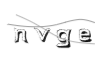

In [7]:
login()
os.remove("captcha.png")

## MSC List

In [8]:
max_rows = list_companies()
msc_df = result(max_rows=max_rows)

In [9]:
msc_df

,Company,Profile
0,CNH Industrial,PGET
1,Mistral Solutions Pvt Ltd,Software Engineer
2,Mistral Solutions Pvt Ltd,FPGA/VLSI Engineer
3,Mistral Solutions Pvt Ltd,RF/Analog Engineer
4,Raphe mPhibr Pvt Ltd,Research Engineer
...,...,...
149,Advantage Club,Business Analyst
150,Auro Digital,Front End Development
151,Auro Digital,Backend Developer
152,Auro Digital,Investment Analyst


## All List

In [10]:
# url = "https://ocs.iitd.ac.in/portal/student/companies"
# class1= "mat-select-value-3"
# class2 = "mat-option-10"
# max_rows = list_companies(url = url, class1=class1, class2=class2)
# all_df = result(max_rows=max_rows)

In [11]:
# all_df

In [12]:
logout()

In [13]:
driver.close()

# Analysis

## Loading the Older List

In [14]:
msc_old = pd.read_csv("msc.csv")
# all_old = pd.read_csv("all.csv")

## Comparing

In [15]:
if len(msc_old)!=len(msc_df):
    print("Some things have changed!")
    changed = True
else:
    print("Everything is the Same.")
    changed = False

Some things have changed!


In [16]:
if changed:
    diff = len(msc_old)-len(msc_df)
    if diff<0:
        print(f"A total of {-diff} Positions have been ADDED.")
    else:
        print(f"A total of {diff} Positions have been REMOVED.")
else:
    diff = 0

A total of 1 Positions have been ADDED.


In [17]:
def compare(diff = diff, anyway = False):
    old_list = msc_old["Company"].values +" "+ msc_old["Profile"].values
    new_list = msc_df["Company"].values +" "+ msc_df["Profile"].values
    if diff<0 or anyway:
        print("Added Positions are:\n")
        for c in new_list:
            if c not in old_list:
                print(c)
    elif diff>0 or anyway:
        print("Removed Positions are:\n")
        for c in old_list:
            if c not in new_list:
                print(c)

In [18]:
compare(diff = diff, anyway = False)

Added Positions are:

CNH Industrial PGET
Ubiquiti Technical Services Pvt Ltd UI/UX Technical Support Engineer


## Saving the Latest List

In [19]:
msc_df.to_csv("msc.csv", index=False)
# all_df.to_csv("all.csv", index=False)

In [20]:
# all_df

In [21]:
msc_df

,Company,Profile
0,CNH Industrial,PGET
1,Mistral Solutions Pvt Ltd,Software Engineer
2,Mistral Solutions Pvt Ltd,FPGA/VLSI Engineer
3,Mistral Solutions Pvt Ltd,RF/Analog Engineer
4,Raphe mPhibr Pvt Ltd,Research Engineer
...,...,...
149,Advantage Club,Business Analyst
150,Auro Digital,Front End Development
151,Auro Digital,Backend Developer
152,Auro Digital,Investment Analyst


In [22]:
msc_df["Company"].value_counts()

Sony Group Corporation       12
Agnikul Cosmos Pvt Ltd       11
MIKO                         10
FourthFrontier                7
Fast Retailing                7
                             ..
WorldQuant                    1
Uber                          1
IQVIA                         1
Flipkart Internet Pvt Ltd     1
HSBC                          1
Name: Company, Length: 73, dtype: int64